In [0]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [0]:
train = pd.read_table("train_data.txt",sep='\t')
train, test = train_test_split(train, test_size=.2, random_state=2)
train=train.sample(frac=1)
test=test.sample(frac=1)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
!pip install transformers

In [0]:
from transformers import BertTokenizer, BertForSequenceClassification

In [0]:
bert_model = 'bert-base-chinese'
max_seq_len = 100
batch_size = 32

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

In [0]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [0]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

In [0]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=100, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

In [0]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [0]:
path = Path(".")

In [0]:
databunch = TextClasDataBunch.from_df(path, train, test,
                  
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="text",
                  label_cols="label",
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [0]:
databunch.show_batch()

text,target
[CLS] 能 借 借 你 的 号 吗 ， 我 是 学 生 ， 明 天 就 上 学 了 ， 我 就 玩 这 一 晚 上 ， 过 后 [SEP],0
[CLS] 我 前 期 给 你 们 送 人 头 给 你 提 个 醒 有 种 你 来 针 对 [SEP],1
[CLS] 那 我 们 俩 先 挂 机 吧 ， 我 手 机 要 没 电 了 ， 快 点 聊 [SEP],0
[CLS] 我 送 了 你 们 举 报 我 又 能 怎 样 ， 反 正 你 们 还 是 输 [SEP],0
[CLS] 没 干 什 么 ， 我 以 为 你 挂 机 了 ， 所 以 就 帮 你 拿 了 [SEP],0


In [0]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [0]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model,num_labels=2)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


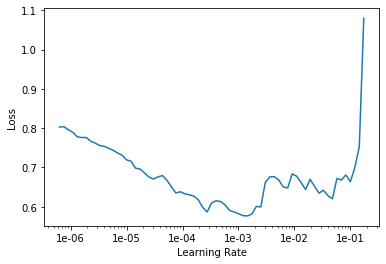

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.530438,0.529957,0.752563,08:05
1,0.507026,0.520874,0.757875,08:08


In [0]:
valid = pd.read_table("validation_data_demo.txt",sep='\t')

In [0]:
def prediction(n):
  pred = []
  for loc in range(n):
    pred.append(int(learn.predict(valid.iloc[loc]['text'])[1]))
  return pred

In [0]:
pred = prediction(len(valid))

In [0]:
pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
print(classification_report(valid.label, pred,digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.90909   0.95238        11
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.90909        11
   macro avg    0.50000   0.45455   0.47619        11
weighted avg    1.00000   0.90909   0.95238        11



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
print(confusion_matrix(valid.label, pred))

[[10  1]
 [ 0  0]]


In [0]:
learn.save('negative_model')